Let's go for RNN based on https://github.com/AbhishekAnand18/ImageTextRecognition/blob/master/ImageTextRecognition_Code.ipynb

In [85]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from IPython.display import clear_output
import time
import os
from skimage.filters import threshold_local
import keras
import random
from keras import backend as K
from skimage.morphology import skeletonize
import itertools


In [86]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

In [87]:
dir_path = "./ORAND-CAR-2014/"
CAR_A_test_images_path = dir_path + 'CAR-A/a_test_images/'
CAR_A_train_images_path = dir_path + 'CAR-A/a_train_images/'
CAR_B_test_images_path = dir_path + 'CAR-B/b_test_images/'
CAR_B_train_images_path = dir_path + 'CAR-B/b_train_images/'

def load_original_images():
    images_path = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith('.png'):
                image_path = os.path.join(root, file)
                images_path.append(image_path.replace('\\','/'))
    return images_path
    
images_path = load_original_images()

def calculate_digit_count(label):
    return len(label)

def get_labels(image_dir,text_path):
  with open(text_path,'r') as f :
    lines = f.readlines()
  listt = []
  for line in lines :
    parts = line.strip().split("\t")
    listt.append([image_dir + parts[0],parts[1]])
  DF = pd.DataFrame(listt)
  DF = DF.rename(columns={0: 'image_path', 1: 'label'})
  return DF

def get_all_labels():
  CAR_A_test_text = dir_path + 'CAR-A/a_test_gt.txt'
  CAR_A_train_text = dir_path + 'CAR-A/a_train_gt.txt'
  CAR_B_test_text = dir_path + 'CAR-B/b_test_gt.txt'
  CAR_B_train_text = dir_path + 'CAR-B/b_train_gt.txt'
  a_test_label_df = get_labels(CAR_A_test_images_path,CAR_A_test_text)
  a_train_label_df = get_labels(CAR_A_train_images_path,CAR_A_train_text)
  b_test_label_df = get_labels(CAR_B_test_images_path,CAR_B_test_text)
  b_train_label_df = get_labels(CAR_B_train_images_path,CAR_B_train_text)
  all_labels = pd.concat([a_test_label_df , a_train_label_df , b_test_label_df , b_train_label_df],ignore_index=True)#.reset_index()
  return all_labels

def reset_data():
  all_labels = get_all_labels()
  print(len(all_labels))
  print(len(all_labels['image_path'].unique())) # no dupicate image name
  all_labels["actual_digit_count"] = all_labels["label"].astype(str).apply(calculate_digit_count)
  return all_labels

all_labels = reset_data()

11719
11719


In [88]:
def get_size_dataFrame(all_labels,column):
  height_list = []
  width_list = []
  for image_path in all_labels[column]:
    height = Image.open(image_path).height
    width = Image.open(image_path).width
    
    height_list.append(height)
    width_list.append(width)

  sizes_df = pd.DataFrame({'width':width_list,'height':height_list})
  return sizes_df

### Processing images functions


In [89]:
def plot_random_image(image_label_df,from_path):
    random.seed(42)
    indices = list(range(len(image_label_df)))
    random.shuffle(indices)

    for idx in indices[:10]+[21,22]:
        target_image = image_label_df[from_path][idx]
        print("label:", image_label_df['label'][idx])
        print("target:", target_image)
        image = mpimg.imread(target_image)
        plt.imshow(image)
        plt.show()
        time.sleep(2)
        clear_output(wait=True)

In [90]:
def convert_to_grayscale(df, from_path,new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, gray_img)
        
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df

In [91]:
def denoise_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        denoised_image = cv2.GaussianBlur(gray_img, (5, 5), 0)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, denoised_image)
        
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df

In [92]:
def denoise_images_fastnlmeans(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        denoised_img = cv2.fastNlMeansDenoising(gray_img, None, h=10, templateWindowSize=7, searchWindowSize=21)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, denoised_img)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df

In [93]:
def local_threshold_images(df, from_path, new_dir_path, block_size, offset):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        binary_img = threshold_local(gray_img, block_size, offset=offset, method='gaussian', mode='reflect', cval=0)
        binary_img = (binary_img * 255).astype(np.uint8)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, binary_img)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df


In [94]:
def binarize_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        im = Image.open(img_path)
        im = np.array(im)
        _, binary_im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        binary_im = Image.fromarray(binary_im)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        binary_im.save(save_path)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df

In [95]:
def invert_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        bin_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        inverted_img = cv2.bitwise_not(bin_img)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, inverted_img)
    
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df

In [96]:
def dilate_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        inverted_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        dilated_img = cv2.dilate(inverted_img, kernel, iterations=1)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, dilated_img)
    
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


In [97]:
def erode_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        inverted_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        eroded_img = cv2.erode(inverted_img, kernel, iterations=1)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, eroded_img)
    
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


In [98]:
def thin_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        inverted_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, binary_img = cv2.threshold(inverted_img, 128, 255, cv2.THRESH_BINARY)
        skeleton = skeletonize(binary_img / 255)
        thin_img = (skeleton * 255).astype(np.uint8)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, thin_img)
    
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


In [99]:
def thin_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        inverted_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, binary_img = cv2.threshold(inverted_img, 128, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        for contour in contours:
            contour_img = np.zeros_like(binary_img)
            cv2.drawContours(contour_img, [contour], -1, 255, thickness=cv2.FILLED)
            binary_img = cv2.bitwise_xor(binary_img, contour_img)
        
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, binary_img)
    
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


In [100]:
def detect_edges_canny(df, from_path, new_dir_path, low_threshold, high_threshold):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        edges = cv2.Canny(gray_img, low_threshold, high_threshold)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, edges)
        
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


resize to specific height

In [101]:
def resize_images_with_height(df,from_path, new_dir_path, target_height):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    
    for i, img_path in enumerate(df[from_path]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        height, width = img.shape
        target_width = int(width * (target_height / height))
        resized_img = cv2.resize(img, (target_width, target_height))
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, resized_img)
    
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df

resize to specific height and width

In [102]:
def resize_images(df,from_path, new_dir_path, target_height,target_width):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    
    for i, img_path in enumerate(df[from_path]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, (target_width, target_height))
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, resized_img)
    
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df

In [103]:
def add_white_padding(df,from_path,new_dir_path, padding_width):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        height, width = img.shape
        new_width = width + 2 * padding_width
        padded_img = 255 * np.ones((height, new_width), dtype=np.uint8)
        start_col = padding_width
        padded_img[:, start_col:start_col + width] = img
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, padded_img)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df

In [104]:
all_labels = reset_data()

11719
11719


## PLOT Images

In [105]:
# plot_random_image(all_labels,'image_path')

## Preproccesing

In [106]:
# Gray scale
all_labels = convert_to_grayscale(all_labels,'image_path','./grayscaled/')

In [107]:
# resize to specific height
# target_height = 28
# all_labels = resize_images_with_height(all_labels,'./grayscaled/', './resized/', target_height)
all_labels = resize_images(all_labels,'./grayscaled/', './resized/', target_height=54,target_width=174)


In [108]:
# padding from right and left

# padding_width = 28
# all_labels = add_white_padding(all_labels, './resized/','./padded/', padding_width)

In [109]:
# Denoising

# all_labels = denoise_images(all_labels, 'image_path', './denoised/')
# all_labels = denoise_images_fastnlmeans(all_labels, './grayscaled/', './denoised_fastnlmeans/')

In [110]:
# binarizing and inverting

# block_size = 9
# offset = 0
# all_labels = local_threshold_images(all_labels, './edges/', './local_thresholded/', block_size, offset)
# all_labels = binarize_images(all_labels, './denoised_fastnlmeans/', './binarized/')
# all_labels = invert_images(all_labels, './denoised_fastnlmeans/', './inverted/')

In [111]:
# thinning and delating

# all_labels = dilate_images(all_labels, './edges/', './dilated/')
# all_labels = erode_images(all_labels, './inverted/', './eroded/')
# all_labels = thin_images(all_labels, './inverted/', './thinned/')
# all_labels = thin_images(all_labels, './inverted/', './c_thinned/')

In [112]:
# edge detecting with canny 

# low_threshold = 50
# high_threshold = 150
# all_labels = detect_edges_canny(all_labels, './denoised_fastnlmeans/', './edges/', low_threshold, high_threshold)

In [113]:
all_labels

,image_path,label,actual_digit_count,./grayscaled/,./resized/
0,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,1500,4,./grayscaled/00000.png,./resized/00000.png
1,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,5743,4,./grayscaled/00001.png,./resized/00001.png
2,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,1056,4,./grayscaled/00002.png,./resized/00002.png
3,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,1000,4,./grayscaled/00003.png,./resized/00003.png
4,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,1000,4,./grayscaled/00004.png,./resized/00004.png
...,...,...,...,...,...
11714,./ORAND-CAR-2014/CAR-B/b_train_images/b_car_00...,100000,6,./grayscaled/11714.png,./resized/11714.png
11715,./ORAND-CAR-2014/CAR-B/b_train_images/b_car_00...,85000,5,./grayscaled/11715.png,./resized/11715.png
11716,./ORAND-CAR-2014/CAR-B/b_train_images/b_car_00...,150000,6,./grayscaled/11716.png,./resized/11716.png
11717,./ORAND-CAR-2014/CAR-B/b_train_images/b_car_00...,13356,5,./grayscaled/11717.png,./resized/11717.png


In [114]:
sizes_df = get_size_dataFrame(all_labels,'./grayscaled/')

In [115]:
sizes_df.describe()

,width,height
count,11719.000000,11719.000000
mean,172.944705,54.925250
std,44.082070,9.066699
min,40.000000,28.000000
25%,144.000000,49.000000
50%,171.000000,54.000000
75%,199.000000,61.000000
max,363.000000,108.000000


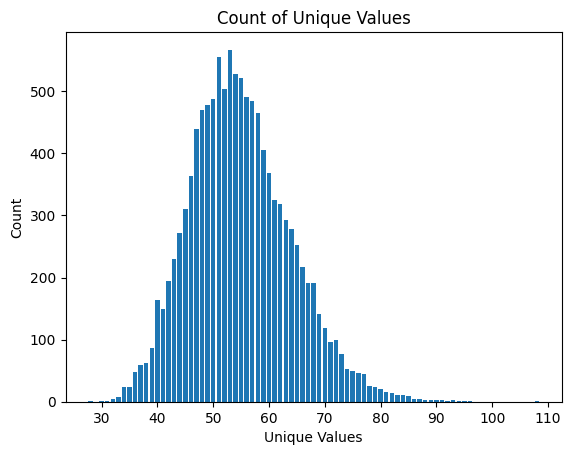

In [116]:
heights = sizes_df['height'].value_counts()
value_counts_df = heights.reset_index()
value_counts_df.columns = ['Value', 'Count']
plt.bar(heights.index, heights.values)
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values')
plt.show()


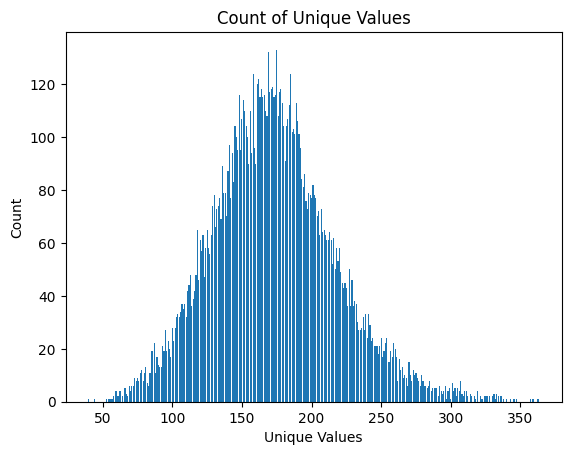

In [117]:
widths = sizes_df['width'].value_counts()
value_counts_df = widths.reset_index()
value_counts_df.columns = ['Value', 'Count']
plt.bar(widths.index, widths.values)
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values')
plt.show()


based on these two plots its better to resize images to 53*173

In [118]:
digits= '0123456789'
img_h=54
img_w=174
#image Channels
img_c=1

# classes for softmax with number of letters +1 for blank space in ctc
num_classes=len(digits) +1
batch_size=64
max_length=8 # considering max length of ground truths labels to be 8

In [119]:
def encode_numbers_labels(number):
    """
    Encodes the Ground Truth Labels to a list of Values like eg.HAT returns [17,10,29]
    """
    label_lst=[]
    for char in str(number):
        label_lst.append(digits.find(char)) # keeping 0 for blank and for padding labels
    return label_lst

In [120]:
def numbers_from_labels(labels):
    txt=[]
    for ele in labels:
        if ele == len(digits): # CTC blank space
            txt.append("")
        else:
            #print(letters[ele])
            txt.append(digits[ele])
    return "".join(txt)

In [121]:
def ctc_loss_function(args):
    y_pred, y_true, input_length, label_length = args 
    y_pred = y_pred[:, 2:, :] # maybe need change based on my project and model architecture
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [122]:
from keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D
from keras.layers import AveragePooling2D, Flatten, Activation, Bidirectional
from keras.layers import BatchNormalization, Dropout
from keras.layers import Concatenate, Add, Multiply, Lambda
from keras.layers import UpSampling2D, Reshape
from keras.layers import add, concatenate
from keras.layers import Reshape
from keras.models import Model
from keras.layers import LSTM,GRU
import tensorflow as tf

In [123]:
def Image_digit_recogniser_model_1(stage,drop_out_rate=0.35):
    img_h=54
    img_w=174
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
        #input shape is (174, 54, 1)  
        #input shape is (174, 54, 64)  
        #input shape is (87, 27, 64)  
        #input shape is (87, 27, 128)
        #input shape is (43, 13, 128)
        #input shape is (43, 13, 256)
        #input shape is (43, 6, 512)
        #input shape is (43, 3, 512)
        #input shape is (43, 1536)
    model_input=Input(shape=input_shape,name='img_input',dtype='float32')

    # Convolution layer 
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model) 

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model) 

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 3), name='max3')(model)  

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model) 

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)    

    # CNN to RNN
    model = Reshape(target_shape=(43, 1024), name='reshape')(model)

    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)  

    # RNN layer
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model) 
    y_pred = Activation('softmax', name='softmax')(model)

    
    labels = Input(name='ground_truth_labels', shape=[max_length], dtype='float32') 
    input_length = Input(name='input_length', shape=[1], dtype='int64') 
    label_length = Input(name='label_length', shape=[1], dtype='int64') 

    #CTC loss function
    loss_out = Lambda(ctc_loss_function, output_shape=(1,),name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

    if stage=='train':
        return model_input,y_pred,Model(inputs=[model_input, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[model_input], outputs=y_pred)  

In [124]:
model_input,y_pred,img_digit_recog=Image_digit_recogniser_model_1('train')

In [125]:
test_func = K.function([model_input], [y_pred])

In [126]:
img_digit_recog.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_input (InputLayer)      [(None, 174, 54, 1)]         0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 174, 54, 64)          640       ['img_input[0][0]']           
                                                                                                  
 batch_normalization_14 (Ba  (None, 174, 54, 64)          256       ['conv1[0][0]']               
 tchNormalization)                                                                                
                                                                                                  
 activation_14 (Activation)  (None, 174, 54, 64)          0         ['batch_normalization_14

In [127]:
all_labels.head()

,image_path,label,actual_digit_count,./grayscaled/,./resized/
0,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,1500,4,./grayscaled/00000.png,./resized/00000.png
1,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,5743,4,./grayscaled/00001.png,./resized/00001.png
2,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,1056,4,./grayscaled/00002.png,./resized/00002.png
3,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,1000,4,./grayscaled/00003.png,./resized/00003.png
4,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,1000,4,./grayscaled/00004.png,./resized/00004.png


# defining data generators

In [128]:
class DataGenerator(keras.callbacks.Callback):
    def __init__(self, df, img_w, img_h, batch_size, max_number_len=8):
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_number_len = max_number_len
        
        self.df = df
        self.n = len(df)
        self.indexes = list(range(self.n))
        self.cur_index = 0
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.numbers = df['label'].tolist()  # Extract related labels from DataFrame
   
   
    def build_data(self):
        print(self.n, " Image Loading start...")
        for i, img_file in enumerate(self.df['./resized/']):
            img = cv2.imread(img_file)
            img = img[:,:,1]                               #Extracting Single Channel Image
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img /255
            self.imgs[i, :, :]= img
            if i%10000==0:
                print("Loaded Images: ",i)
           
        print("Number of Texts matches with Total Number of Images :",len(self.numbers) == self.n)
        print(self.n, " Image Loading finish...")
    
    def next_data(self): 
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.numbers[self.indexes[self.cur_index]]

    def next_batch(self):
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_number_len])* -1   
            input_length = np.ones((self.batch_size, 1)) * 40
            label_length = np.zeros((self.batch_size, 1))                   #label length for CTC
            source_str=[]                                                   #List to store Ground Truth Labels
            for i in range(self.batch_size):
                img, text = self.next_data() #getting the image and text data pointed by current index
                                    #taking transpose of image
                img=img.T
                img = np.expand_dims(img, -1)  #expanding image to have a single channel
                X_data[i] = img
                label=encode_numbers_labels(text) # encoding label text to integer list and storing in temp label variable
                lbl_len=len(label)
                Y_data[i,0:lbl_len] = label #Storing the label till its length and padding others
                label_length[i] = len(label)
                source_str.append(text) #storing Ground Truth Labels which will be accessed as reference for calculating metrics
            
        #Preparing the input for the Model
            inputs = {
                'img_input': X_data,  
                'ground_truth_labels': Y_data,  
                'input_length': input_length,  
                'label_length': label_length,
                'source_str': source_str  # used for visualization only
            }
            #Preparing output for the Model and intializing to zeros
            outputs = {'ctc': np.zeros([self.batch_size])}  
            yield (inputs, outputs) # Return the Prepared input and output to the Model

In [129]:
train_gene = DataGenerator(all_labels[:10000], img_w, img_h, batch_size, max_number_len=8)
train_gene.build_data()
train_num_batches=int(train_gene.n / batch_size)

10000  Image Loading start...
Loaded Images:  0
Number of Texts matches with Total Number of Images : True
10000  Image Loading finish...


In [130]:
val_gen=DataGenerator(all_labels[10000:], img_w, img_h, batch_size, max_number_len=8)
val_gen.build_data()
val_num_batches=int(val_gen.n / batch_size)

1719  Image Loading start...
Loaded Images:  0
Number of Texts matches with Total Number of Images : True
1719  Image Loading finish...


In [131]:
def decode_batch(test_func, number_batch):
    out = test_func([number_batch])[0] #returns the predicted output matrix of the model
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = numbers_from_labels(out_best)
        ret.append(outstr)
    return ret

In [132]:
def accuracies(actual_labels,predicted_labels,is_train):
    accuracy=0
    letter_acc=0
    letter_cnt=0
    count=0
    for i in range(len(actual_labels)):
        predicted_output=predicted_labels[i]
        actual_output=actual_labels[i]
        count+=1
        for j in range(min(len(predicted_output),len(actual_output))):
            if predicted_output[j]==actual_output[j]:
                letter_acc+=1
        letter_cnt+=max(len(predicted_output),len(actual_output))
        if actual_output==predicted_output:
            accuracy+=1
    final_accuracy=np.round((accuracy/len(actual_labels))*100,2)
    final_letter_acc=np.round((letter_acc/letter_cnt)*100,2)
    return final_accuracy,final_letter_acc

## callback visualizer

In [133]:
class VizCallback(keras.callbacks.Callback):
    """
    The Custom Callback created for printing the Accuracy and Letter Accuracy Metrics at the End of Each Epoch
    """

    def __init__(self, test_func, text_img_gen,is_train,acc_compute_batches):
        self.test_func = test_func
        self.text_img_gen = text_img_gen
        self.is_train=is_train                #used to indicate whether the callback is called to for Train or Validation Data
        self.acc_batches=acc_compute_batches  # Number of Batches for which the metrics are computed typically equal to steps/epoch

    def show_accuracy_metrics(self,num_batches):
        """
        Calculates the accuracy and letter accuracy for each batch of inputs, 
        and prints the avarage accuracy and letter accuracy across all the batches
        """
        accuracy=0
        letter_accuracy=0
        batches_cnt=num_batches
        while batches_cnt>0:
            number_batch = next(self.text_img_gen)[0]   #Gets the next batch from the Data generator
            decoded_res = decode_batch(self.test_func,number_batch['img_input'])
            actual_res=number_batch['source_str']
            acc,let_acc=accuracies(actual_res,decoded_res,self.is_train)
            accuracy+=acc
            letter_accuracy+=let_acc
            batches_cnt-=1
        accuracy=accuracy/num_batches
        letter_accuracy=letter_accuracy/num_batches
        if self.is_train:
            print("Train Average Accuracy of "+str(num_batches)+" Batches: ",np.round(accuracy,2)," %")
            print("Train Average Letter Accuracy of "+str(num_batches)+" Batches: ",np.round(letter_accuracy,2)," %")
        else:
            print("Validation Average Accuracy of "+str(num_batches)+" Batches: ",np.round(accuracy,2)," %")
            print("Validation Average Letter Accuracy of "+str(num_batches)+" Batches: ",np.round(letter_accuracy,2)," %")
            
        
    def on_epoch_end(self, epoch, logs={}):
        self.show_accuracy_metrics(self.acc_batches)

In [134]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [135]:
import datetime

In [136]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
early_stop=EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)
model_chk_pt=ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=False,save_weights_only=True,verbose=0, mode='auto', period=2)
logdir = os.path.join("logs_127", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [137]:
# %tensorboard --logdir logs_127

In [138]:
viz_cb_train = VizCallback( test_func, train_gene.next_batch(),True,train_num_batches)
viz_cb_val = VizCallback( test_func, val_gen.next_batch(),False,val_num_batches)

In [139]:
from keras import optimizers
adam=optimizers.Adam()

In [140]:
img_digit_recog.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=adam)

In [141]:
history = img_digit_recog.fit(
    train_gene.next_batch(),
    steps_per_epoch=int(train_gene.n / batch_size),
    epochs=20,
    #callbacks=[viz_cb_train, viz_cb_val, train_gene, val_gen, tensorboard_callback, early_stop, model_chk_pt],
    validation_data=val_gen.next_batch(),
    validation_steps=int(val_gen.n / batch_size)
)


Epoch 1/20


C:\Users\rajab\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\functional.py:639: UserWarning: Input dict contained keys ['source_str'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 41/156 [======>.......................] - ETA: 12:28 - loss: 14.8805

KeyboardInterrupt: 